In [1]:
import os 
import torch 

In [2]:
labels = ["MI", "STTC", "CD", "HYP", "NORM"]

In [3]:
from functions import load_models

768 [[768, 384], [192, 12]] [[30, 30], [10, 4]] [[5, 2], [1, 1]]
768 [[768, 384], [192, 12]] [[30, 30], [10, 4]] [[5, 2], [1, 1]]
768 [[768, 384], [192, 12]] [[30, 30], [10, 4]] [[5, 2], [1, 1]]


C:\Users\ugo-c\anaconda3\envs\dcaesr\lib\site-packages\torch\serialization.py:1525: UserWarning: This figure was saved with matplotlib version 3.7.1 and is unlikely to function correctly.
  result = unpickler.load()


768 [[768, 384], [192, 12]] [[30, 30], [10, 4]] [[5, 2], [1, 1]]
768 [[768, 384], [192, 12]] [[30, 30], [10, 4]] [[5, 2], [1, 1]]


{'denoising_hr': VAE1d_SR_multimodal(
   (encoder): Encoder1d(
     (encoder): Sequential(
       (0): EncoderBlock1d(
         (conv1d_in): Conv1d(12, 12, kernel_size=(3,), stride=(1,))
         (activation_in): Tanh()
         (dropout_in): Dropout(p=0.1, inplace=False)
         (conv1d_out): Conv1d(12, 192, kernel_size=(3,), stride=(1,))
         (activation_out): Tanh()
         (dropout_out): Dropout(p=0.1, inplace=False)
       )
       (1): EncoderBlock1d(
         (conv1d_in): Conv1d(192, 384, kernel_size=(3,), stride=(1,))
         (activation_in): Tanh()
         (dropout_in): Dropout(p=0.1, inplace=False)
         (conv1d_out): Conv1d(384, 768, kernel_size=(3,), stride=(1,))
         (activation_out): Tanh()
         (dropout_out): Dropout(p=0.1, inplace=False)
       )
     )
   )
   (decoder): Decoder1d(
     (decoder): Sequential(
       (0): DecoderBlock1d(
         (conv1d_in): ConvTranspose1d(768, 768, kernel_size=(3,), stride=(1,))
         (activation_in): Tanh()
   

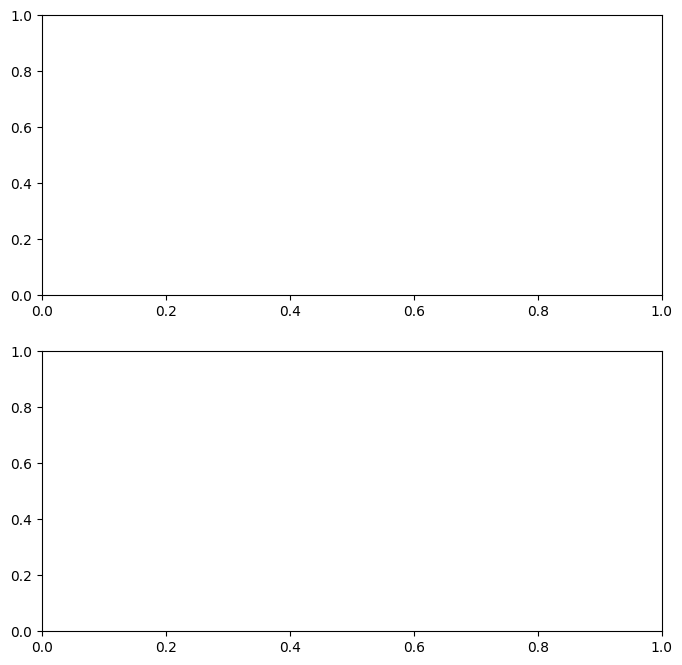

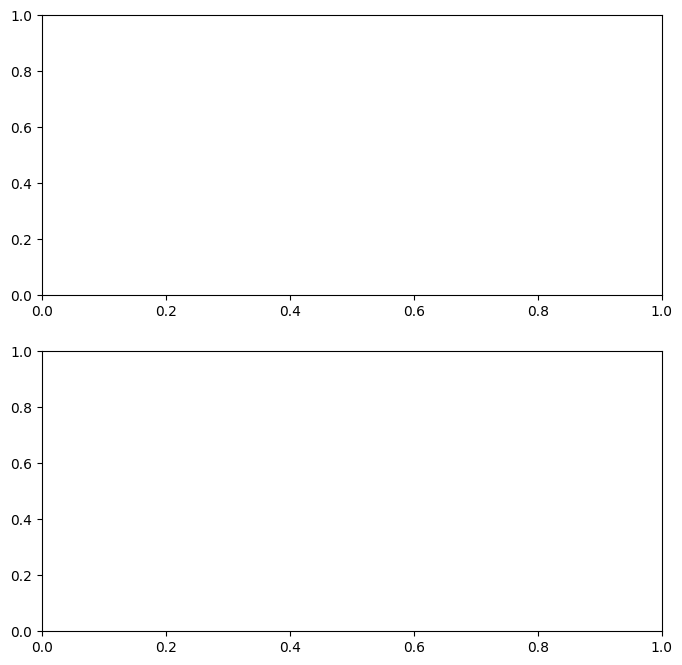

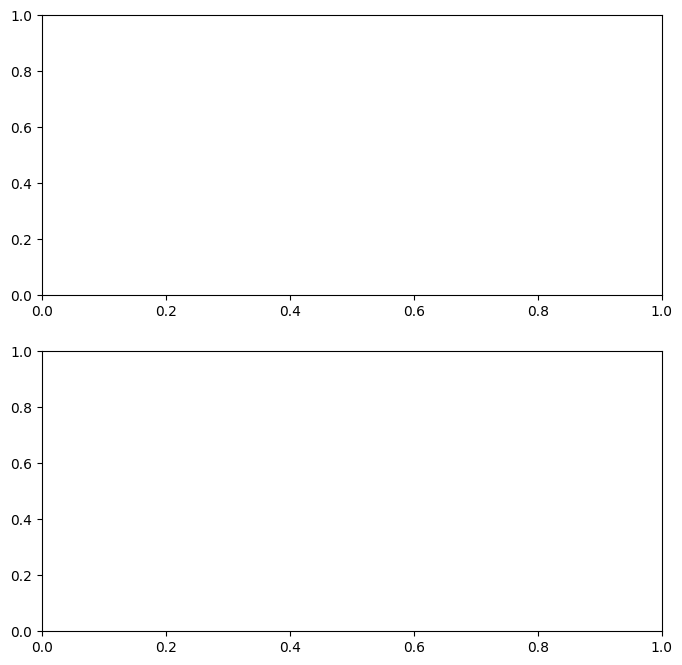

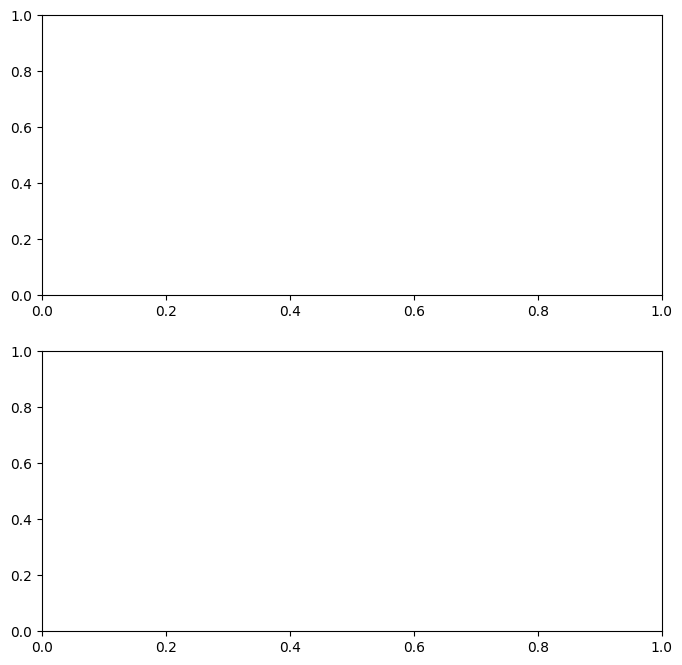

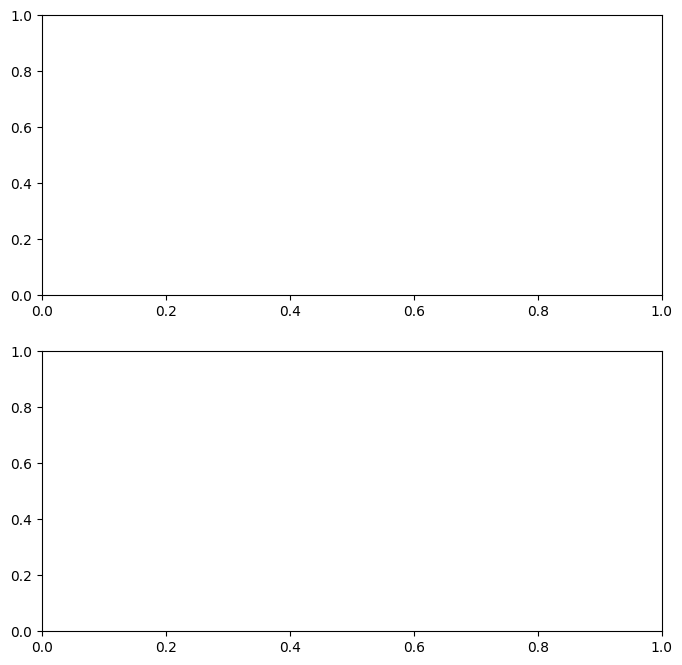

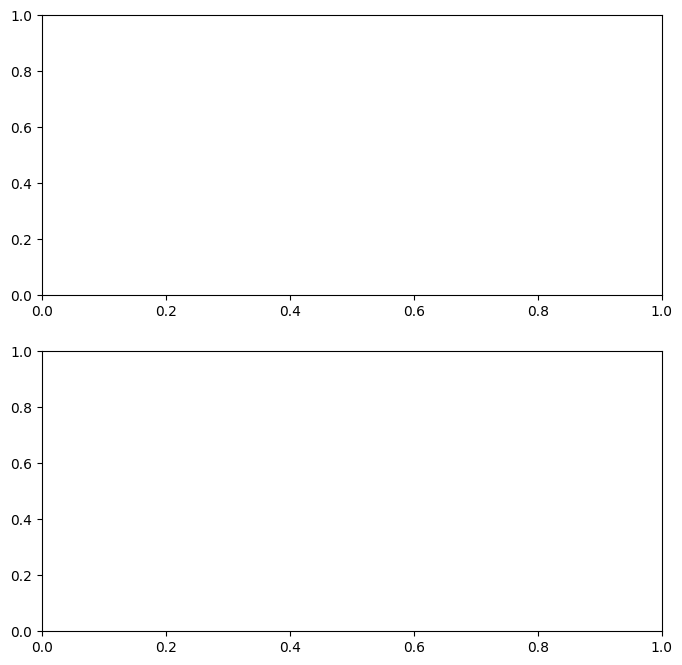

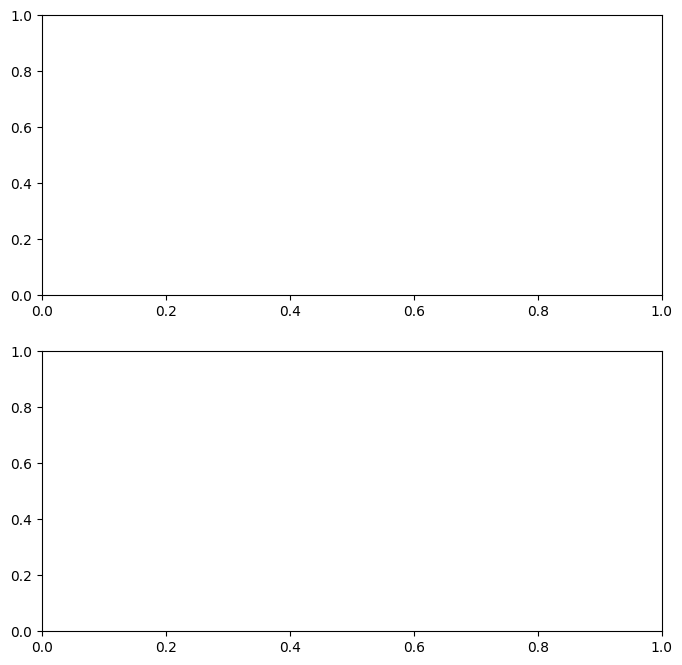

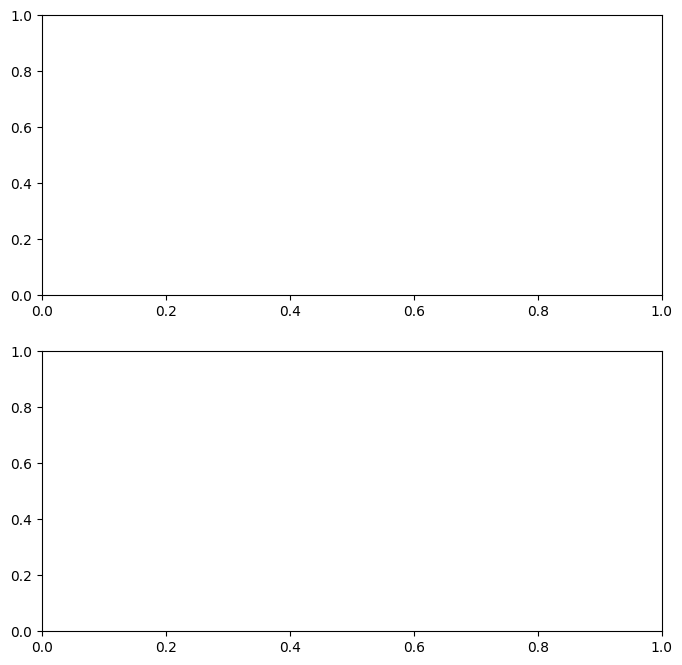

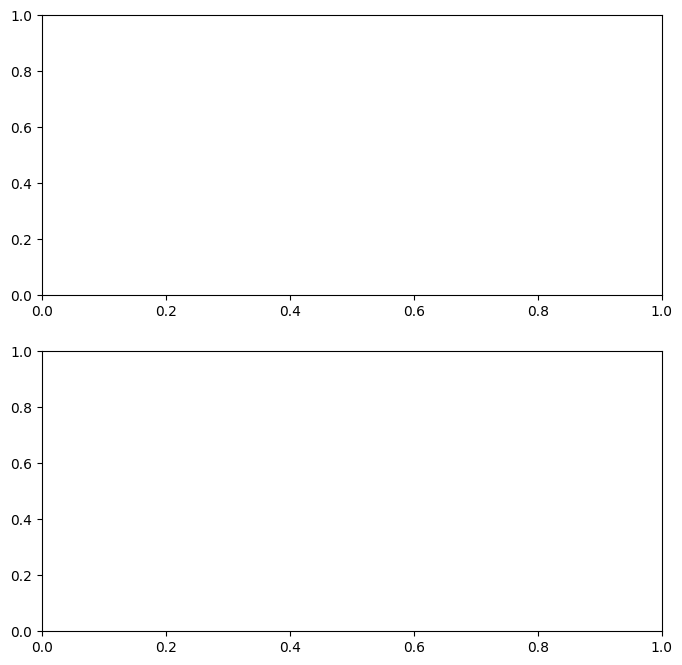

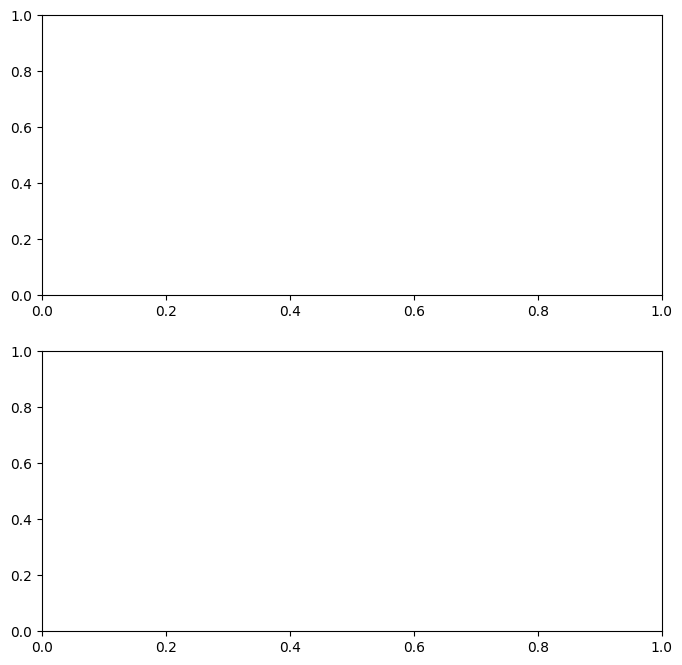

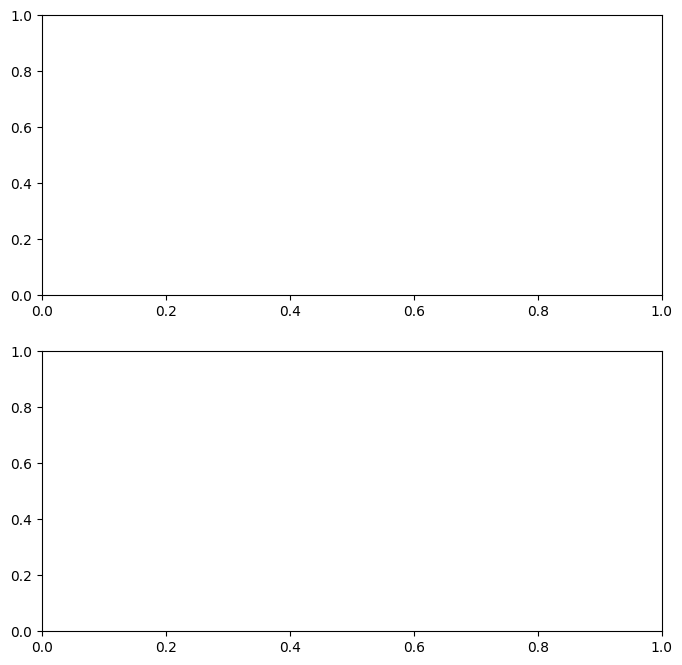

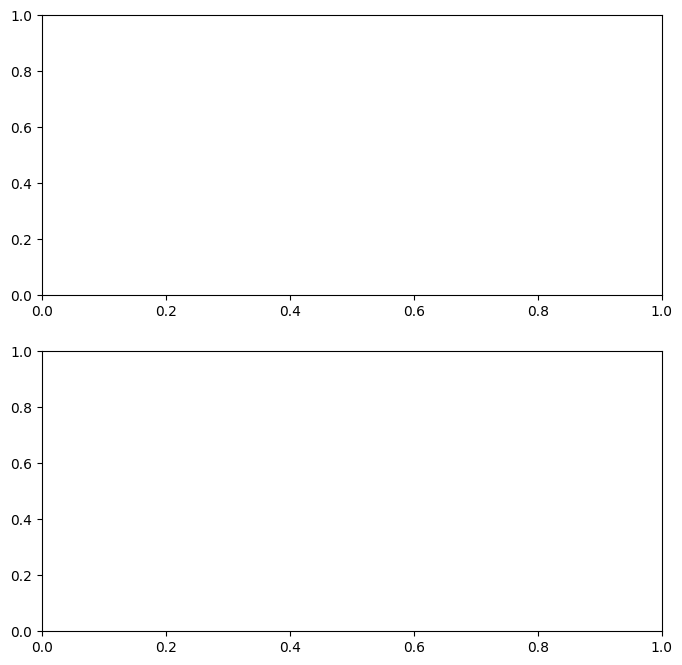

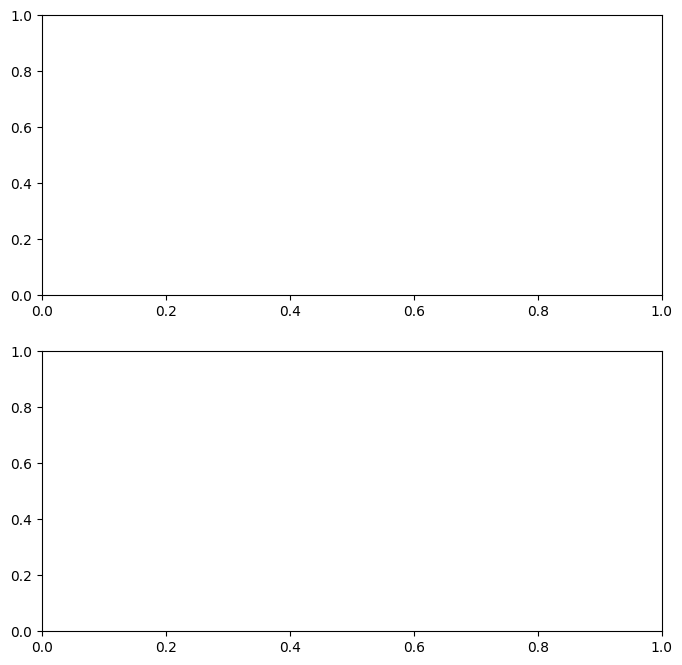

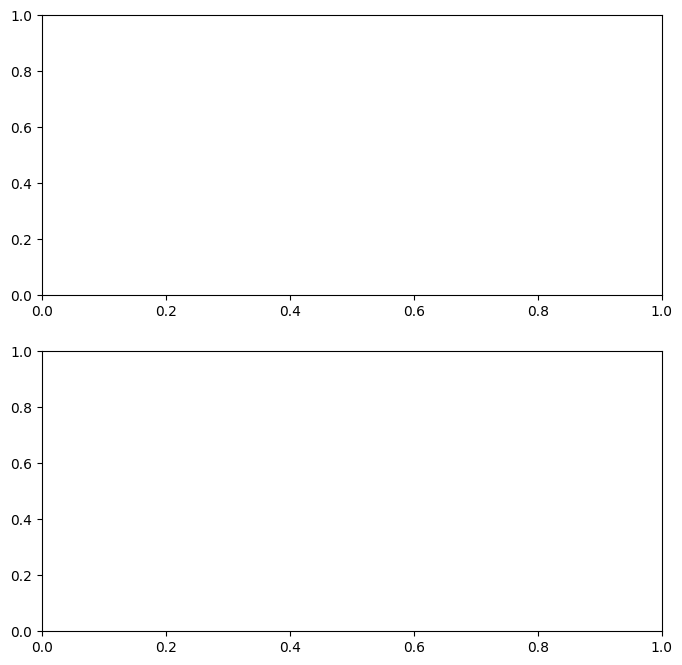

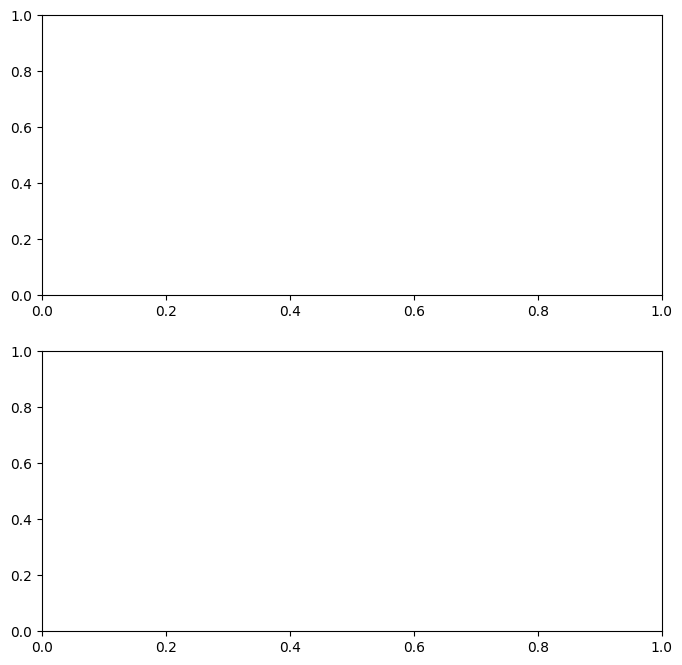

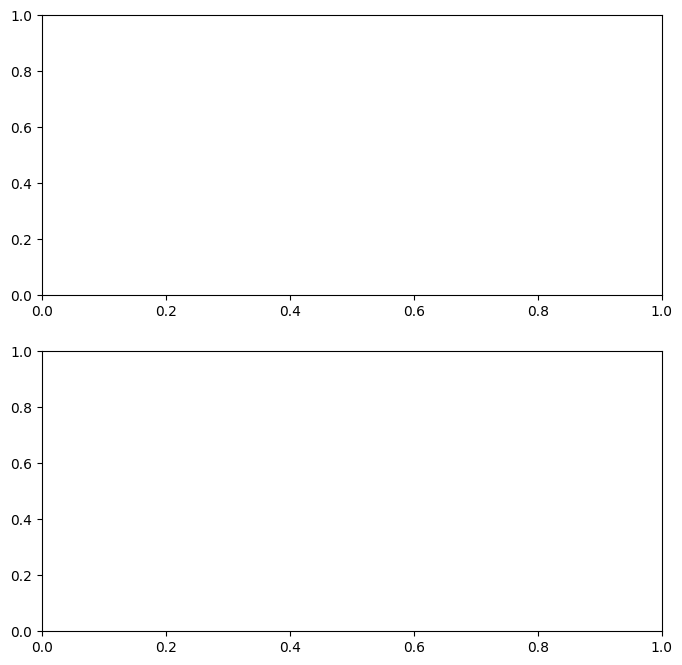

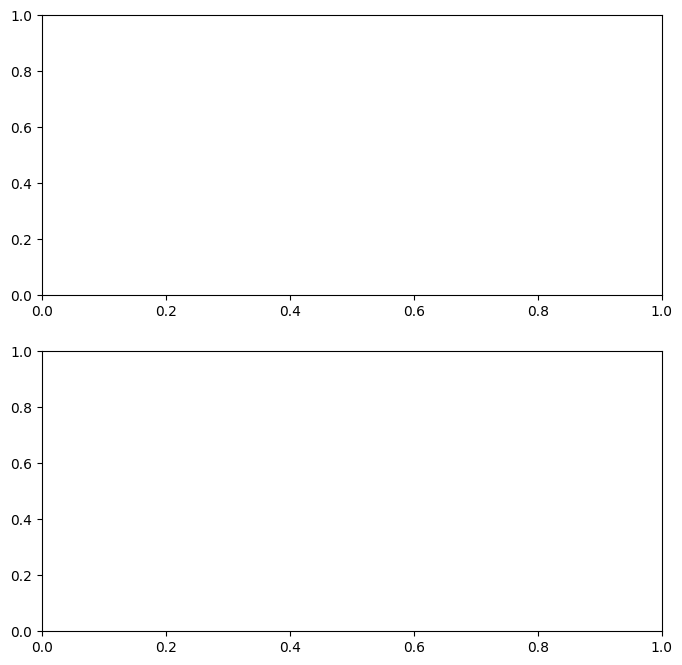

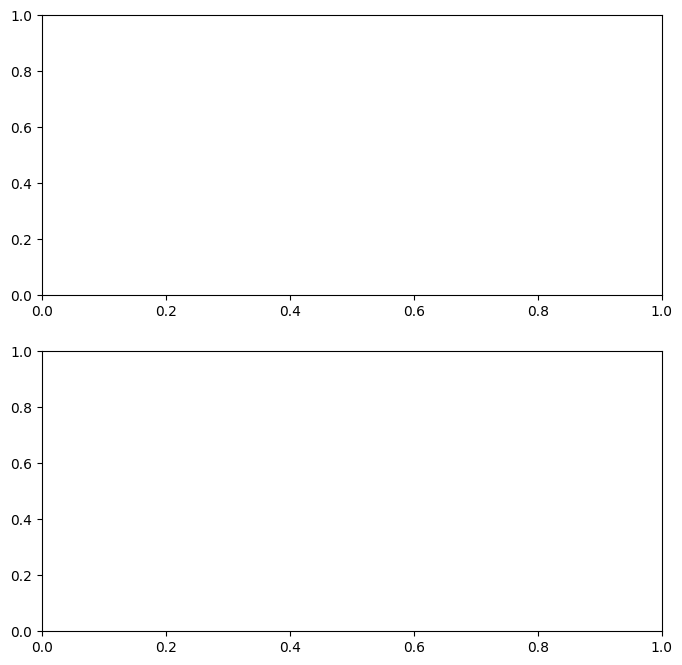

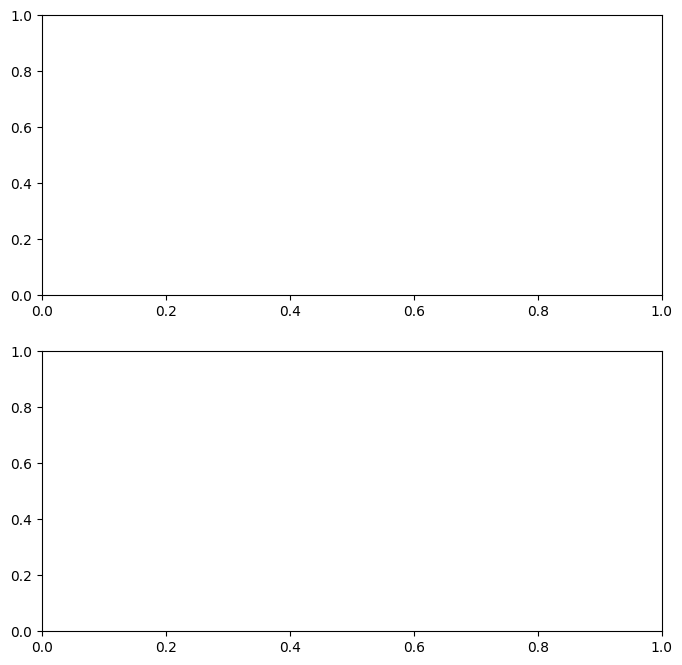

In [4]:
models, _ = load_models()
models

In [7]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [9]:
models.keys()

dict_keys(['denoising_hr', 'denoising_lrhr', 'denoising_lrhr_v2', 'denoising_nosr', 'nodenoising', 'nodenoising_nosr'])

In [43]:
model_d = models["denoising_lrhr_v2"].to(device)
model = models["nodenoising"].to(device)

In [11]:
dict_windows_test_hr = {}
dict_windows_test_lr = {}
dict_windows_train_lr = {}
dict_windows_test_lr_n = {}
dict_windows_train_lr_n = {}
dict_windows_train_hr = {}
path = os.getcwd()+os.sep+"pt_data"+os.sep

for label in labels:

    filename = path + "test_{}_hr.pt".format(label)
    hr_data = torch.load(filename)
    dict_windows_test_hr[label] = hr_data

    filename = path + "test_{}_50.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_test_lr[label] = lr_data
    
    
    filename = path + "test_{}_noisy.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_test_lr_n[label] = lr_data

    filename = path + "train_{}_hr.pt".format(label)
    hr_data = torch.load(filename)
    dict_windows_train_hr[label] = hr_data

    filename = path + "train_{}_50.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_train_lr[label] = lr_data
    
    filename = path + "train_{}_noisy.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_train_lr_n[label] = lr_data

dict_windows_train = dict_windows_train_lr
dict_windows_test = dict_windows_test_lr

In [44]:
def interpolate_sr(signal, fs_lr=50, fs_hr = 500, nchs=12, mode = 'cubic'):
    # Interpolation to 500 Hz
    t_low_res = np.arange(0, 5, 1/fs_lr)
    t_high_res = np.arange(0, 5, 1/fs_hr)  # 500 Hz sampling rate
    f_interp = interpolate.interp1d(t_low_res, signal, kind=mode, fill_value="extrapolate")
    signal_sr = f_interp(t_high_res)
    return signal_sr

In [45]:
from functions import myfilter

In [207]:
from torch.functional import F
import numpy as np 
from scipy import interpolate 
import matplotlib.pyplot as plt 

def visual_comparison(label = "NORM", idx = 0, ch = 0, limit = None):

    hr_data = dict_windows_test_hr[label][idx][0]
    lr_data = dict_windows_test_lr_n[label][idx][0]
    #print(lr_data.shape, hr_data.shape)
    sr_data_d = model_d([lr_data.to(device), None, None, None])[1].cpu().detach().numpy()
    lr_data_filt = myfilter(0.5, lr_data.cpu(), powerline = None)
    lr_data_interp = interpolate_sr(lr_data_filt)
    sr_data = model([lr_data_filt.to(device), None, None, None])[1].cpu().detach().numpy()

    lr_data = lr_data.cpu().detach().numpy()
    hr_data = hr_data.cpu().detach().numpy()
    hr_data = hr_data[ch]
    lr_data = lr_data[ch]
    sr_data_d = sr_data_d[ch]
    sr_data = sr_data[ch]
    lr_data_interp = lr_data_interp[ch]
    
    if limit is not None:
        if isinstance(limit, list):
            if len(limit) == 2:
                min_, max_ = limit
                hr_data = hr_data[min_:max_]
                sr_data = sr_data[min_:max_]
                lr_data = lr_data[min_:max_]
                sr_data_d = sr_data_d[min_:max_]
                lr_data_interp = lr_data_interp[min_:max_]
                
    fig = plt.figure()
    plt.plot(lr_data_interp, label = "Filter + Interpolation", linewidth = 0.8, color = "b")
    plt.plot(sr_data, label = "CAE-SR",  linewidth = 0.8, color = "red")
    plt.plot(sr_data_d, label = "DCAE-SR", linewidth = 2, color = "magenta")
    plt.plot(hr_data, label = "High Resolution Target",  linewidth = 1.5, color = "g")
    plt.xlabel("Samples [#]")
    plt.ylabel("Amplitude [mV]")
    plt.legend()
    return fig

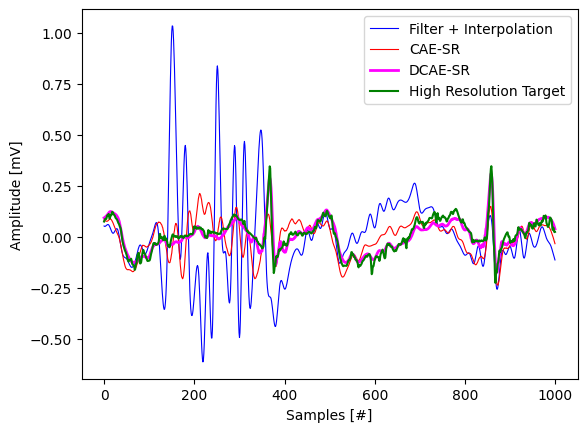

In [212]:
fig = visual_comparison(label = "NORM", idx = 0, ch = 0, limit = [1000, 2000])
fig.savefig("emg_visualcomparison.png", dpi = 600)

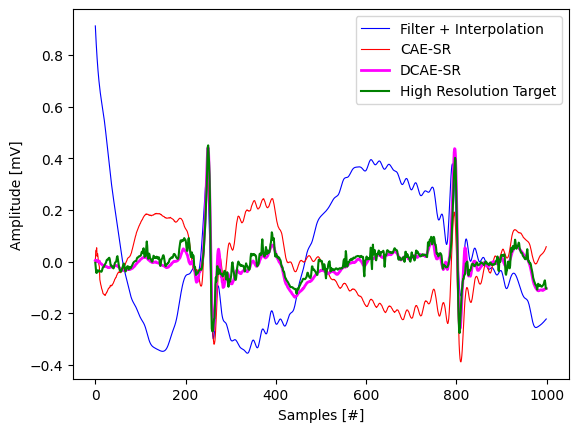

In [209]:
fig = visual_comparison(label = "NORM", idx = 10, ch = 0, limit = [0, 1000])
fig.savefig("eda_visualcomparison.png", dpi = 600)

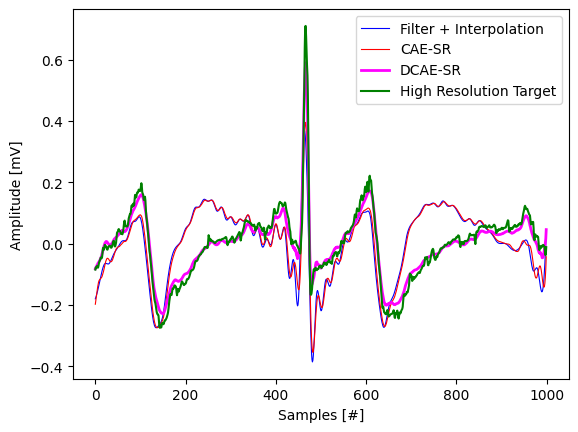

In [210]:
fig = visual_comparison(label = "NORM", idx = 40, ch = 0, limit = [1000, 2000])
fig.savefig("clean_visualcomparison.png", dpi = 600)

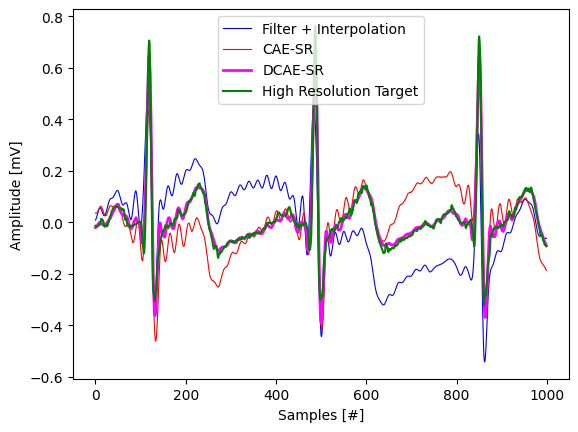

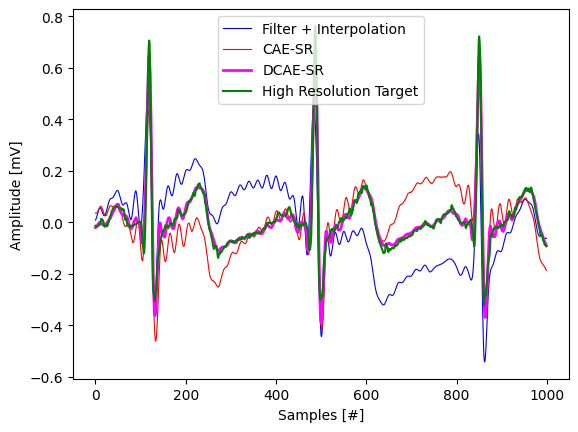

In [211]:
fig = visual_comparison(label = "NORM", idx = 119, ch = 0, limit = [500, 1500])
fig.savefig("bw_visualcomparison.png", dpi = 600)
fig